# rGreat online vs local 

This notebook allows you to compare results between local and online rGreat. 

r-base == 3.6.1

python version == 3.8 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import r as r
pandas2ri.activate()
import pandas as pd

import os 
import matplotlib.pyplot as plt
import greatpy as great 
from scipy.stats import pearsonr
import re
import time 

In [3]:
rpy2.__version__

'3.5.2'

In [5]:
importr('rGREAT')
ranges = importr('GenomicRanges')

In [8]:
def local_vs_online(): 
    stat_df = {
        "name" : [],
        "pearson_binom" : [], 
        "pearson_hypergeom" : []
    }
    pp = {
        "name" : [],
        "before_pp_online_size" : [], 
        "before_pp_local_size" : [],
        "final_size" : [],
        "%_of_GO_from_online_lost" : [],
    }

    for name in os.listdir("../../data/tests/test_data/input"): 
        # find the assembly 
        if re.match(".*hg19.*",name) != None : 
            assembly = "hg19"
        else : 
            assembly = "hg38"
            
        # online test 
        res_online = rpy2.robjects.r['submitGreatJob'](f"../../data/tests/test_data/input/{name}",species=f"{assembly}",help=False)
        res_online = rpy2.robjects.r['getEnrichmentTables'](res_online)

        # local test
            # proprocessing : make a Grange frame 
        df = r["read.csv"](f"../../data/tests/test_data/input/{name}",sep='\t')
        seqname = rpy2.robjects.StrVector(["seqnames", "seqname","chromosome", "X.Chr","chr", "chromosome_name","seqid"])
        end = rpy2.robjects.StrVector(['end', 'stop'])
        df = ranges.makeGRangesFromDataFrame(df,seqnames_field=seqname)#,keep_extra_columns=False,ignore_strand=False,seqinfo=None,start_field='start', end_field=end, strand_field='strand',starts_in_df_are_0based=False)

            # great calculation
        local = rpy2.robjects.r['great'](df, "msigdb:C5", f"txdb:{assembly}",verbose=False)
        local = rpy2.robjects.r['getEnrichmentTables'](local)

        # create each dataframe
        name = [cdc.lower() for cdc in list(res_online.rx2("GO Molecular Function").rx2("name"))+list(res_online.rx2("GO Biological Process").rx2("name"))+list(res_online.rx2("GO Cellular Component").rx2("name"))]

        online = pd.DataFrame({
            "id" : list(res_online.rx2("GO Molecular Function").rx2("ID"))+list(res_online.rx2("GO Biological Process").rx2("ID"))+list(res_online.rx2("GO Cellular Component").rx2("ID")),
            "name" : name,
            "binom_p_val" : list(res_online.rx2("GO Molecular Function").rx2("Binom_Raw_PValue"))+list(res_online.rx2("GO Biological Process").rx2("Binom_Raw_PValue"))+list(res_online.rx2("GO Cellular Component").rx2("Binom_Raw_PValue")),
            "hyper_p_val" : list(res_online.rx2("GO Molecular Function").rx2("Hyper_Raw_PValue"))+list(res_online.rx2("GO Biological Process").rx2("Hyper_Raw_PValue"))+list(res_online.rx2("GO Cellular Component").rx2("Hyper_Raw_PValue"))
            })

        name = list(local.rx2("id")) 
        name = [" ".join(cdc.lower().split("_")[1:]) for cdc in list(local.rx2("id"))]

        local = pd.DataFrame({
            "name": name,
            "binom_p_val" : list(local.rx2("p_value")),
            "hyper_p_val" : list(local.rx2("p_value_hyper"))
            })

        # reduce the df 
        pp["name"].append(name)
        pp["before_pp_local_size"].append(local.shape[0])
        pp["before_pp_online_size"].append(online.shape[0])
        local = local.loc[local["name"].isin(list(online["name"]))]
        online = online.loc[online["name"].isin(list(local["name"]))]
        pp["final_size"].append(local.shape[0])
        pp["%_of_GO_from_online_lost"].append(round(100*(online.shape[0]-local.shape[0])/online.shape[0],2))

        # compare
        binom_local = []
        hyper_local = []
        binom_online = []
        hyper_online = []
        for i in range(online.shape[0]) : 
            go_term = list(online["name"])[i]
            curr_enrichment = online.iloc[i]
            curr_great_webserver = local.loc[local["name"]==go_term]
            binom_local.append(float(curr_enrichment["binom_p_val"]))
            hyper_local.append(float(curr_enrichment["hyper_p_val"]))
            binom_online.append(float(curr_great_webserver["binom_p_val"]))
            hyper_online.append(float(curr_great_webserver["hyper_p_val"]))
        binom = pd.DataFrame({"binom_local":binom_local,"binom_online":binom_online})
        hyper = pd.DataFrame({"hyper_local":hyper_local,"hyper_online":hyper_online})


        # fig = plt.figure(figsize=(10,5))
        # fig.subplots_adjust(hspace=0.4, wspace=0.4)
        # ax = fig.add_subplot(2, 2, 1)
        # great.pl.scatterplot(binom,colname_x="binom_local",colname_y="binom_online",title=None,ax = ax)
        # ax = fig.add_subplot(2, 2, 2)
        # great.pl.scatterplot(hyper,colname_x="hyper_local",colname_y="hyper_online",title=None,ax = ax)
        # fig.suptitle(f"results for {name}")
        # plt.show()
        # Error : 
        # ValueError: Image size of 896244x195 pixels is too large. It must be less than 2^16 in each direction.
        # <Figure size 720x360 with 2 Axes>

        stat_df["name"].append(name[0])
        stat_df["pearson_binom"].append(pearsonr(binom_local,binom_online)[0])
        stat_df["pearson_hypergeom"].append(pearsonr(hyper_local,hyper_online)[0])

        time.sleep(30) # just to have not a burning computer ^^ 
        
    return pd.DataFrame(stat_df),pd.DataFrame(pp)

In [9]:
stat,preprocess = local_vs_online()

R[write to console]: The default enrichment tables contain no associated genes for the input
regions.You can set `download_by = 'tsv'` to download the complete
table,but note only the top 500 regions can be retreived. See the
following link:

https://great-help.atlassian.net/wiki/spaces/GREAT/pages/655401/Export#Export-GlobalExport

R[write to console]: * extended_tss is already cached, directly use it.

R[write to console]: The default enrichment tables contain no associated genes for the input
regions.You can set `download_by = 'tsv'` to download the complete
table,but note only the top 500 regions can be retreived. See the
following link:

https://great-help.atlassian.net/wiki/spaces/GREAT/pages/655401/Export#Export-GlobalExport



In [47]:
stat_df = {
    "name" : [],
    "pearson_binom": [], 
    "pearson_hypergeom": []
}
res_online = rpy2.robjects.r['submitGreatJob'](f"../../data/tests/test_data/input/09_ERF.bed",species=f"hg38",help=False)
res_online = rpy2.robjects.r['getEnrichmentTables'](res_online)

# local test
    # proprocessing : make a Grange frame 
df = r["read.csv"](f"../../data/tests/test_data/input/09_ERF.bed",sep='\t')
seqname = rpy2.robjects.StrVector(["seqnames", "seqname","chromosome", "X.Chr","chr", "chromosome_name","seqid"])
end = rpy2.robjects.StrVector(['end', 'stop'])
df = ranges.makeGRangesFromDataFrame(df,seqnames_field=seqname)#,keep_extra_columns=False,ignore_strand=False,seqinfo=None,start_field='start', end_field=end, strand_field='strand',starts_in_df_are_0based=False)

    # great calculation
local = rpy2.robjects.r['great'](df, "msigdb:C5", f"txdb:hg38",verbose=False)
local = rpy2.robjects.r['getEnrichmentTables'](local)

# create each dataframe
name = [cdc.lower() for cdc in list(res_online.rx2("GO Molecular Function").rx2("name"))+list(res_online.rx2("GO Biological Process").rx2("name"))+list(res_online.rx2("GO Cellular Component").rx2("name"))]

online = pd.DataFrame({
    "id":list(res_online.rx2("GO Molecular Function").rx2("ID"))+list(res_online.rx2("GO Biological Process").rx2("ID"))+list(res_online.rx2("GO Cellular Component").rx2("ID")),
    "name":name,
    "binom_p_val" : list(res_online.rx2("GO Molecular Function").rx2("Binom_Raw_PValue"))+list(res_online.rx2("GO Biological Process").rx2("Binom_Raw_PValue"))+list(res_online.rx2("GO Cellular Component").rx2("Binom_Raw_PValue")),
    "hyper_p_val":list(res_online.rx2("GO Molecular Function").rx2("Hyper_Raw_PValue"))+list(res_online.rx2("GO Biological Process").rx2("Hyper_Raw_PValue"))+list(res_online.rx2("GO Cellular Component").rx2("Hyper_Raw_PValue"))
    })

name = list(local.rx2("id")) 
name = [" ".join(cdc.lower().split("_")[1:]) for cdc in list(local.rx2("id"))]

local = pd.DataFrame({
    "name": name,
    "binom_p_val" : list(local.rx2("p_value")),
    "hyper_p_val" : list(local.rx2("p_value_hyper"))
    })



R[write to console]: The default enrichment tables contain no associated genes for the input
regions.You can set `download_by = 'tsv'` to download the complete
table,but note only the top 500 regions can be retreived. See the
following link:

https://great-help.atlassian.net/wiki/spaces/GREAT/pages/655401/Export#Export-GlobalExport

R[write to console]: * extended_tss is already cached, directly use it.



In [48]:

# reduce the df 
local = local.loc[local["name"].isin(list(online["name"]))]
online = online.loc[online["name"].isin(list(local["name"]))]

# compare
binom_local = []
hyper_local = []
binom_online = []
hyper_online = []


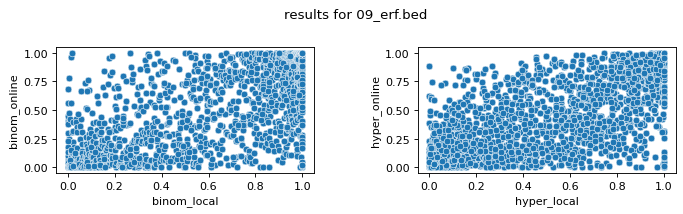

In [53]:
for i in range(online.shape[0]) : 
    go_term = list(online["name"])[i]
    curr_online = online.iloc[i]
    curr_local = local.loc[local["name"]==go_term]
    binom_local.append(float(curr_online["binom_p_val"]))
    hyper_local.append(float(curr_online["hyper_p_val"]))
    binom_online.append(float(curr_local["binom_p_val"]))
    hyper_online.append(float(curr_local["hyper_p_val"]))
binom = pd.DataFrame({"binom_local":binom_local,"binom_online":binom_online})
hyper = pd.DataFrame({"hyper_local":hyper_local,"hyper_online":hyper_online})


fig = plt.figure(figsize=(10,5),dpi=80)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
great.pl.scatterplot(binom,colname_x="binom_local",colname_y="binom_online",title=None,ax = ax,minus_log10=False)
ax = fig.add_subplot(2, 2, 2)
great.pl.scatterplot(hyper,colname_x="hyper_local",colname_y="hyper_online",title=None,ax = ax,minus_log10=False)
fig.suptitle(f"results for 09_erf.bed")
plt.show()

stat_df["name"].append(name[0])
stat_df["pearson_binom"].append(pearsonr(binom_local,binom_online)[0])
stat_df["pearson_hypergeom"].append(pearsonr(hyper_local,hyper_online)[0])

In [39]:
pd.DataFrame(stat_df)

,name,pearson_binom,pearson_hypergeom
0,[retrograde vesicle mediated transport golgi t...,6.02501e-01,4.42513e-01
1,retrograde vesicle mediated transport golgi to...,6.02501e-01,4.42513e-01


In [78]:
df = r["read.csv"]("../../data/tests/test_data/input/01_random.bed",sep = '\t')
seqname = rpy2.robjects.StrVector(["seqnames", "seqname","chromosome", "X.Chr","chr", "chromosome_name","seqid"])
# # pos = rpy2.robjects.StrVector(["start","end", "stop"])
# # grange = r["makeGRangesFromDataFrame"](df,False,False,None,seqname,pos,"strand",False)
df = ranges.makeGRangesFromDataFrame(df,seqnames_field=seqname)#,keep_extra_columns=False,ignore_strand=False,seqinfo=None,seqnames_field=['seqnames', 'seqname','chromosome', 'X.Chr','chr', 'chromosome_name','seqid'],start_field='start', end_field=['end', 'stop'], strand_field='strand',starts_in_df_are_0based=False)

In [35]:
print(gr)

GRanges object with 1000 ranges and 0 metadata columns:
         seqnames            ranges strand
            <Rle>         <IRanges>  <Rle>
     [1]     chr1   4019588-4027467      *
     [2]     chr1   7842161-7848599      *
     [3]     chr1 11043010-11048806      *
     [4]     chr1 11898610-11901557      *
     [5]     chr1 12428038-12437382      *
     ...      ...               ...    ...
   [996]     chrY 46810671-46817467      *
   [997]     chrY 48947701-48954502      *
   [998]     chrY 52129635-52132878      *
   [999]     chrY 55147206-55149155      *
  [1000]     chrY 57402986-57407067      *
  -------
  seqinfo: 26 sequences from an unspecified genome; no seqlengths



In [76]:
res_online = rpy2.robjects.r['submitGreatJob']("../../data/tests/test_data/input/01_random.bed",species="hg38",help=False)
res_online = rpy2.robjects.r['getEnrichmentTables'](res_online)

R[write to console]: The default enrichment tables contain no associated genes for the input
regions.You can set `download_by = 'tsv'` to download the complete
table,but note only the top 500 regions can be retreived. See the
following link:

https://great-help.atlassian.net/wiki/spaces/GREAT/pages/655401/Export#Export-GlobalExport

R[write to console]: 



RRuntimeError: Error in file(file, "rt") : cannot open the connection


In [61]:
gr = rpy2.robjects.r["randomRegions"](genome = "hg38")
test = rpy2.robjects.r["great"](gr, "MSigDB:H", "txdb:hg38",verbose=False)

R[write to console]: * extended_tss is already cached, directly use it.



In [59]:
test.names

<rpy2.rinterface_lib.sexp.NULLType object at 0x7fe1f0219640> [RTYPES.NILSXP]

In [79]:
res_local = rpy2.robjects.r['great'](df, "msigdb:C5", "txdb:hg38",verbose=False)
res_local = rpy2.robjects.r['getEnrichmentTables'](res_local)

R[write to console]: * extended_tss is already cached, directly use it.



In [84]:
" ".join("GOBP_RETROGRADE_VESICLE_MEDIATED_TRANSPORT_GOLGI_TO_ENDOPLASMIC_RETICULUM".lower().split("_")[1:])

'retrograde vesicle mediated transport golgi to endoplasmic reticulum'

In [85]:
# print(res_local.names)
# print(res_local.rx2("id"))
# print(res_local.rx2("p_value"))

name = list(res_local.rx2("id")) 
name = [" ".join(cdc.lower().split("_")[1:]) for cdc in list(res_local.rx2("id"))]

pd.DataFrame({
    "name": name,
    "binom_p_val" : list(res_local.rx2("p_value")),
    "hypergeom_p_val" : list(res_local.rx2("p_value_hyper"))
    })

,name,binom_p_val,hypergeom_p_val
0,retrograde vesicle mediated transport golgi to...,1.776357e-15,0.011076
1,regulation of deoxyribonuclease activity,2.453593e-13,0.000441
2,cis golgi network,4.408141e-12,0.000001
3,golgi vesicle transport,6.894041e-12,0.011977
4,regulation of nuclease activity,2.545886e-11,0.001826
...,...,...,...
572,negative regulation of response to stimulus,9.932918e-01,0.952320
573,neuron projection,9.943098e-01,0.920691
574,regulation of intracellular signal transduction,9.949570e-01,0.886667
575,tissue development,9.977504e-01,0.981626


In [30]:
print(res_online.rx2("GO Molecular Function").colnames)

 [1] "ID"                         "name"                      
 [3] "Binom_Genome_Fraction"      "Binom_Expected"            
 [5] "Binom_Observed_Region_Hits" "Binom_Fold_Enrichment"     
 [7] "Binom_Region_Set_Coverage"  "Binom_Raw_PValue"          
 [9] "Binom_Adjp_BH"              "Hyper_Total_Genes"         
[11] "Hyper_Expected"             "Hyper_Observed_Gene_Hits"  
[13] "Hyper_Fold_Enrichment"      "Hyper_Gene_Set_Coverage"   
[15] "Hyper_Term_Gene_Coverage"   "Hyper_Raw_PValue"          
[17] "Hyper_Adjp_BH"             



In [75]:
name = list(res_online.rx2("GO Molecular Function").rx2("name"))+list(res_online.rx2("GO Biological Process").rx2("name"))+list(res_online.rx2("GO Cellular Component").rx2("name"))
online = pd.DataFrame({
    "id":list(res_online.rx2("GO Molecular Function").rx2("ID"))+list(res_online.rx2("GO Biological Process").rx2("ID"))+list(res_online.rx2("GO Cellular Component").rx2("ID")),
    "term":list(res_online.rx2("GO Molecular Function").rx2("name"))+list(res_online.rx2("GO Biological Process").rx2("name"))+list(res_online.rx2("GO Cellular Component").rx2("name")),
    "binom_p_val" : list(res_online.rx2("GO Molecular Function").rx2("Binom_Raw_PValue"))+list(res_online.rx2("GO Biological Process").rx2("Binom_Raw_PValue"))+list(res_online.rx2("GO Cellular Component").rx2("Binom_Raw_PValue")),
    "hyper_p_val":list(res_online.rx2("GO Molecular Function").rx2("Hyper_Raw_PValue"))+list(res_online.rx2("GO Biological Process").rx2("Hyper_Raw_PValue"))+list(res_online.rx2("GO Cellular Component").rx2("Hyper_Raw_PValue"))
    })
online.sort_values(by=["binom_p_val"])

,id,term,binom_p_val,hyper_p_val
4222,GO:0071103,DNA conformation change,2.523846e-15,0.009131
4223,GO:0010556,regulation of macromolecule biosynthetic process,6.080676e-14,0.000297
4224,GO:0006029,proteoglycan metabolic process,3.328065e-13,0.000003
4225,GO:0051276,chromosome organization,3.541375e-13,0.025078
4226,GO:0031326,regulation of cellular biosynthetic process,5.049125e-13,0.000339
...,...,...,...,...
9408,GO:0009128,purine nucleoside monophosphate catabolic process,1.000000e+00,1.000000
9409,GO:0009129,pyrimidine nucleoside monophosphate metabolic ...,1.000000e+00,1.000000
9410,GO:0009130,pyrimidine nucleoside monophosphate biosynthet...,1.000000e+00,1.000000
9384,GO:0008637,apoptotic mitochondrial changes,1.000000e+00,1.000000
